# Lab 06 - Neural networks
## Tasks
- Train a neural network to fit the MNIST dataset
- Train a neural network to fit data from the AWA photoinjector

# Set up environment

In [1]:
%reset -f

import os
import numpy as np
import matplotlib.pyplot as plt

#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

#add PyTorch and TorchVision (used for cropping etc.)
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

cwd = os.getcwd()

## Load training and test data
To start with we will be training a neural network to identify handwritten numbers. The input of this neural network will be the flattened image data (28 x 28 px) from the MNIST dataset (shape is 784 x 1). The output layer is a set of 10 neurons each representing an integer from 0-9. The neurons return between 0-1 based on the likelihood that a given number is in the image.

In [2]:
#create objects to load and pre-process the data
batch_size_train = 1024
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(cwd + '/files/', train=True, download=True,
                                 transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                     (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(cwd + '/files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                     (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_test, shuffle=True)


Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /home/vagrant/jupyter/2021_optimization_and_ml/lab_solutions/lab_06/files/MNIST/raw/train-images-idx3-ubyte.gz to /home/vagrant/jupyter/2021_optimization_and_ml/lab_solutions/lab_06/files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /home/vagrant/jupyter/2021_optimization_and_ml/lab_solutions/lab_06/files/MNIST/raw/train-labels-idx1-ubyte.gz to /home/vagrant/jupyter/2021_optimization_and_ml/lab_solutions/lab_06/files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /home/vagrant/jupyter/2021_optimization_and_ml/lab_solutions/lab_06/files/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/vagrant/jupyter/2021_optimization_and_ml/lab_solutions/lab_06/files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /home/vagrant/jupyter/2021_optimization_and_ml/lab_solutions/lab_06/files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/vagrant/jupyter/2021_optimization_and_ml/lab_solutions/lab_06/files/MNIST/raw

Processing...


/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


## Examine the data

torch.Size([1000, 1, 28, 28])


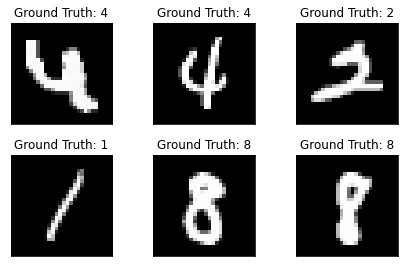

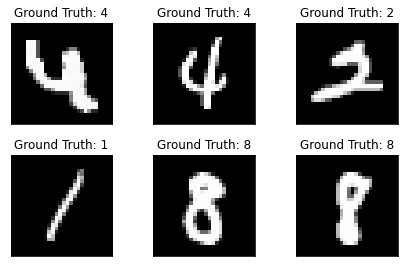

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

## Build the model (using fully connected layers)

In [4]:
# we use a simple fully connected network using one hidden layer with a ReLU activation function
# the output layer is a log_softmax layer that normalizes the output such that the sum of outputs is one. 
# See https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html for details
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        
        hidden_size = 20
        
        self.linear1 = nn.Linear(784, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        #note that the data x is shape (batch_size, 1, 28, 28) need to reshape to flatten image -> (batch_size, 1, 784)
        x = x.view((x.shape[0], 784))
        
        #propagate through model
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        
        return F.log_softmax(x)

In [5]:

learning_rate = 0.1
momentum = 0.5
log_interval = 10

fully_connected_model = NN()
optimizer = optim.SGD(fully_connected_model.parameters(), lr=learning_rate,
                      momentum=momentum)

## Train the model

<div class="alert alert-block alert-info">
    
**Task:** 
    Insert code inside the training loop in the training function below. Then train the model and plot the loss as a function of training steps. The loss function in this case is `F.mse_loss()`.
</div>

In [6]:
def train_model(model, epochs, train_loader):
    
    train_losses = []
    train_counter = []
    
    #set network to training mode
    model.train()
    
    #iterate through data batches
    for batch_idx, (data, target) in enumerate(train_loader):
        ################################################################
        #ANSWER KEY START
        ################################################################
        
        #reset gradients
        optimizer.zero_grad()
        
        #evaluate network with data
        output = model(data)

        #compute loss and derivative
        loss = F.nll_loss(output, target)
        #loss = F.mse_loss(output, F.one_hot(target, 10).float())
        loss.backward()
        
        #step optimizer
        optimizer.step()
        
        ################################################################
        #ANSWER KEY END
        ################################################################
        #print out results and save to file
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(model.state_dict(), cwd + '/results/model.pth')
        torch.save(optimizer.state_dict(), cwd + '/results/optimizer.pth')
        
    return train_losses, train_counter

In [7]:
def test_model(model):
    test_losses = []
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_losses

In [8]:
################################################################
#ANSWER KEY
################################################################
train_losses = []
test_losses = []
n_epochs = 5
for epoch in range(1, n_epochs + 1):
    train_losses += train_model(fully_connected_model, epoch, train_loader)[0]
    test_losses += test_model(fully_connected_model)


/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325342
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.759462
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.497159
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.401577
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.415208
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.342943


/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3408, Accuracy: 8989/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.362931
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.375262
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.351516
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.315899
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.310869
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.277157

Test set: Avg. loss: 0.2859, Accuracy: 9182/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.291481
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.295219
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.279194
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.266688
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.265498
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.265763

Test set: Avg. loss: 0.2632, Accuracy: 9235/10000 (92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.287705
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.269027
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.294500
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.252889
Train Epoch: 4 [40960/60000 (68%)]	Loss: 

Text(0, 0.5, 'mse loss')

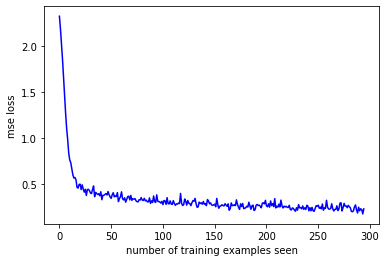

In [9]:
fig, ax = plt.subplots()
ax.plot(train_losses, color='blue')
ax.set_xlabel('number of training examples seen')
ax.set_ylabel('mse loss')

## Build model with CNN Layers
For the MNIST data set it is reasonable to use a fully connected network. If we have larger images then this scales poorly and becomes impractical quickly. Instead we can use a Convolutional neural network (CNN).

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

## Train the model

<div class="alert alert-block alert-info">
    
**Task:** 
    Train the CNN model and plot the loss as a function of number of training examples seen.
</div>

In [11]:
################################################################
#ANSWER KEY
################################################################
cnn_model = CNN()
optimizer = optim.SGD(cnn_model.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
test_losses = []
n_epochs = 5
for epoch in range(1, n_epochs + 1):
    train_losses += train_model(cnn_model, epoch, train_loader)[0]
    test_losses += test_model(cnn_model)

/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316207
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.159377
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.349822
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.906966
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.821069
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.669783

Test set: Avg. loss: 0.3361, Accuracy: 9089/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.626808
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.575629
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.512442
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.469574
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.455907
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.492023

Test set: Avg. loss: 0.1854, Accuracy: 9440/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.456131
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.411411
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.476469
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.409553
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.377294
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.376042

Text(0, 0.5, 'negative log likelihood loss')

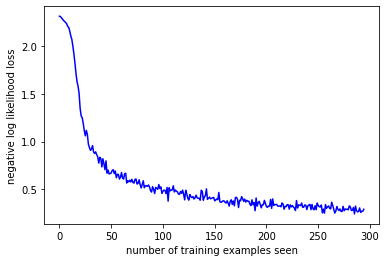

In [12]:
fig, ax = plt.subplots()
ax.plot(train_losses, color='blue')
ax.set_xlabel('number of training examples seen')
ax.set_ylabel('negative log likelihood loss')

## NN for AWA Photoinjector
<div class="alert alert-block alert-success">
    
**Homework:**
    
Now its your turn! Implement and train a NN model to perform regression on data from the AWA photoinjector.
    
- The input layer should accept 7 parameters and return 6 parameters
- Start with 3 hidden layers with 20 neurons each and tanh activiation functions (since we are doing regression, not classification)
- Use the MSELoss function `torch.nn.functional.mse_loss()`
- Try 3 different NN designs and compare their accuracy after 5 epochs.
</div>

In [13]:
#load AWA data
df = pd.read_pickle('AWA_train.pkl')
features = ['P0','P1','G0','G1','K1','K2']
targets = ['rms_x','rms_y','rms_s','emit_x','emit_y','emit_s','dE']

n_train = 70000
n_test = 30000
batch_size = 1024

#create test and train datasets
train_data = torch.utils.data.TensorDataset(torch.tensor(df.head(n_train)[features].values).float(),
                                            torch.tensor(df.head(n_train)[targets].values).float())

test_data = torch.utils.data.TensorDataset(torch.tensor(df.tail(n_test)[features].values).float(),
                                           torch.tensor(df.tail(n_test)[targets].values).float())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)



torch.Size([1024, 6])


In [14]:
class AWANN(nn.Module):
    def __init__(self):
        super(AWANN, self).__init__()

        hidden_size = 20
        self.linear1 = nn.Linear(6, hidden_size)
        self.tanh1 = nn.Tanh()
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.tanh2 = nn.Tanh()
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.tanh3 = nn.Tanh()
        self.linear4 = nn.Linear(hidden_size, 7)

    def forward(self, x):
        # propagate through model
        x = self.linear1(x)
        x = self.tanh1(x)
        x = self.linear2(x)
        x = self.tanh2(x)
        x = self.linear3(x)
        x = self.tanh3(x)
        x = self.linear4(x)
        
        return x

In [15]:
def train_model(model, epochs, train_loader):
    
    train_losses = []
    train_counter = []
    
    #set network to training mode
    model.train()
    
    #iterate through data batches
    for batch_idx, (data, target) in enumerate(train_loader):
        ################################################################
        #ANSWER KEY START
        ################################################################
        
        #reset gradients
        optimizer.zero_grad()
        
        #evaluate network with data
        output = model(data)

        #compute loss and derivative
        loss = F.mse_loss(output, target)
        loss.backward()
        
        #step optimizer
        optimizer.step()
        
        ################################################################
        #ANSWER KEY END
        ################################################################
        #print out results and save to file
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(model.state_dict(), cwd + '/results/model.pth')
        torch.save(optimizer.state_dict(), cwd + '/results/optimizer.pth')
        
    return train_losses, train_counter

In [16]:
def test_model(model):
    test_losses = []
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.mse_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    return test_losses

In [17]:
################################################################
#ANSWER KEY
################################################################
awa_model = AWANN()
optimizer = optim.SGD(awa_model.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
test_losses = []
n_epochs = 5
for epoch in range(1, n_epochs + 1):
    train_losses += train_model(awa_model, epoch, train_loader)[0]
    test_losses += test_model(awa_model)

Train Epoch: 1 [0/70000 (0%)]	Loss: 0.377519
Train Epoch: 1 [10240/70000 (14%)]	Loss: 0.139863
Train Epoch: 1 [20480/70000 (29%)]	Loss: 0.108342
Train Epoch: 1 [30720/70000 (43%)]	Loss: 0.093574
Train Epoch: 1 [40960/70000 (58%)]	Loss: 0.083217
Train Epoch: 1 [51200/70000 (72%)]	Loss: 0.064004
Train Epoch: 1 [61440/70000 (87%)]	Loss: 0.047402


/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 2 [0/70000 (0%)]	Loss: 0.036907
Train Epoch: 2 [10240/70000 (14%)]	Loss: 0.032424
Train Epoch: 2 [20480/70000 (29%)]	Loss: 0.026313
Train Epoch: 2 [30720/70000 (43%)]	Loss: 0.028438
Train Epoch: 2 [40960/70000 (58%)]	Loss: 0.026216
Train Epoch: 2 [51200/70000 (72%)]	Loss: 0.022989
Train Epoch: 2 [61440/70000 (87%)]	Loss: 0.022026
Train Epoch: 3 [0/70000 (0%)]	Loss: 0.023547
Train Epoch: 3 [10240/70000 (14%)]	Loss: 0.019713
Train Epoch: 3 [20480/70000 (29%)]	Loss: 0.020355
Train Epoch: 3 [30720/70000 (43%)]	Loss: 0.016715
Train Epoch: 3 [40960/70000 (58%)]	Loss: 0.018957
Train Epoch: 3 [51200/70000 (72%)]	Loss: 0.015204
Train Epoch: 3 [61440/70000 (87%)]	Loss: 0.016590
Train Epoch: 4 [0/70000 (0%)]	Loss: 0.022695
Train Epoch: 4 [10240/70000 (14%)]	Loss: 0.019131
Train Epoch: 4 [20480/70000 (29%)]	Loss: 0.019146
Train Epoch: 4 [30720/70000 (43%)]	Loss: 0.013917
Train Epoch: 4 [40960/70000 (58%)]	Loss: 0.015015
Train Epoch: 4 [51200/70000 (72%)]	Loss: 0.014705
Train Epoch: 4 